# AMC Metrics Status Report (FY2018-2019)

[Task](https://phabricator.wikimedia.org/T226661)
[Anlaysis Codebase]()

##  Summary ##

The Advance mobile contributions (AMC) mode is a feature set that adds more contributor capabilities to the mobile web experience ([project page](https://www.mediawiki.org/wiki/Reading/Web/Advanced_mobile_contributions#Background)). This report shows the status of the KPIs identified in the Annual Plan as of the end of June 2019. 

The feature was was first deployed as an opt-in setting on Arabic, Indonesian, and Spanish Wikipedias on March 20, 2019 due to their relatively large populations of existing mobile editors. On June 17, 2019, the team released a second set of features and included additional Wikipedias for testing and feedback (Italian, Japanese, Persian, and Thai). Please seel the full list of [target wikis](https://www.mediawiki.org/wiki/Reading/Web/Advanced_mobile_contributions#Per_project).

This report reflects the status of the KPIs as of the end of FY18-19 (June 2019). AMC is still in the process of being deployed and has not yet been promoted. Metrics will be re-caculated following full rolllout and promotion and Q1.

## Metrics ##
In the annual plan, the Readers Web team defined the following KPis:

**Mobile web edit rate on target wikis**.
- Target: 10% increase from last year (overall metric).
- Mobile web edits are defined using the existing edit tag.
- Also reviewed tag edits from the new AMC edits tag  (done in [T212959](https://phabricator.wikimedia.org/T212959)) to see if they reach 1/11th of total mobile web edits, defined using the existing edit tag.

**Retention rate for opt-in advanced mobile mode amongst medium and high-volume editors (100+ edits previous month)** ( eswiki, arwiki, idwiki, thwiki, itwiki, jawiki, fawiki (overall, 100+ edits, 500+ edits).
- Target: At least 60% retention.
- Measured using the opt-in/opt-out button  (done in [T211197](https://phabricator.wikimedia.org/T211197) using the [PrepUpdate](https://meta.wikimedia.org/wiki/Schema:PrefUpdate) mf_amc_optin). This is set to true each time someone opts out.

**Moderation actions on mobile web on target wikis**
- Target: 10% increase from last year - via the logs - not looking at AMC only but overall.
- Moderation actions are defined in [T213461](https://phabricator.wikimedia.org/T213461)

For more links to implementation tasks and technical details, see this overview task [T210660](https://phabricator.wikimedia.org/T210660)

## Mobile Web Edit Rate ##

For this report, we reviewed the mobile edit rate on the following:
- Rate on target wikis where deployed: eswiki, arwiki, idwiki, itwiki, jawiki, fawiki, thwiki
- overall rate across target wikis where AMC has been deployed
- overall rate among active editors, in particular medium and high-volume editors (100+ edits 500+ edits).
- proportion of AMC tagged edits out of the total mobile web edits defined using existing tag.

Notes: 
- The tag identifies which edits come from users that have AMC enabled.
- Article editing should be performed in the mobile mode.
- Articles should be tagged advanced mobile edit and mobile web edit when AMC interface enabled


In [191]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [633]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(glue); library(lubridate)
    library(scales)
})


In [ ]:
#Collect all mobile web edits along mobile web edits tagged as AMC from all target wikis where AMC was deployed 
#grouped by user edit count

# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

query <- "select
    date_format(event_timestamp, 'yyyy-MM-dd') as date,
    wiki_db as wiki,
    user_edit_count,
    sum(cast(mobile_web_edit as int)) as mobile_web_edits,
    sum(cast(amc_edit as int)) as amc_edits
from (
    select
        wiki_db,
        event_timestamp,
        array_contains(revision_tags, 'mobile web edit') as mobile_web_edit, 
        array_contains(revision_tags, 'advanced mobile edit') as amc_edit,
        CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count < 100 THEN 'under 100'
            WHEN event_user_revision_count >= 100 AND event_user_revision_count < 500 THEN '100-499'
            ELSE '500+'
            END AS user_edit_count
    from wmf.mediawiki_history
    where
        event_entity = 'revision' and
        event_type = 'create' and
        event_timestamp IS NOT NULL and
        wiki_db in ('eswiki', 'arwiki', 'idwiki', 'itwiki', 'jawiki', 'fawiki', 'thwiki') and
        event_timestamp between '2018-06-01' and '2019-06-30' and 
        snapshot = '2019-06'
) edits
group by wiki_db, date_format(event_timestamp, 'yyyy-MM-dd'), user_edit_count"


results <- collect(sql(query))
save(results, file="R/Data/mobile_web_edit_counts.RData")

In [630]:
load("Data/mobile_web_edit_counts.RData")
mobile_web_edit_counts <- results

In [631]:
mobile_web_edit_counts$date <- as.Date(mobile_web_edit_counts$date, format = "%Y-%m-%d")

mobile_web_edit_counts_clean <-  mobile_web_edit_counts %>%
gather(edit_type, edit_count, mobile_web_edits:amc_edits) %>%
    arrange(date)

### Overall rate across all target wikis ###

In [739]:
##Overall monthly web edit counts and yoy change
mobile_web_edit_monthly_overall_yoy <- mobile_web_edit_counts_clean %>%
filter(edit_type == 'mobile_web_edits') %>% 
mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)

mobile_web_edit_monthly_overall_yoy


date,total_mobile_edits,yearOverYear
<date>,<dbl>,<dbl>
2018-06-01,271192,NA
2018-07-01,263999,NA
2018-08-01,289015,NA
2018-09-01,284295,NA
2018-10-01,301943,NA
2018-11-01,282857,NA
2018-12-01,293722,NA
2019-01-01,341384,NA
2019-02-01,304855,NA


In [634]:
vertical_lines <- as.numeric(as.Date(c("2019-03-20", "2019-06-17")))

In [637]:
head(mobile_web_edit_counts_clean)

date,wiki,user_edit_count,edit_type,edit_count
<date>,<chr>,<chr>,<chr>,<dbl>
2018-06-01,idwiki,undefined,mobile_web_edits,122
2018-06-01,jawiki,undefined,mobile_web_edits,687
2018-06-01,idwiki,100-499,mobile_web_edits,34
2018-06-01,jawiki,100-499,mobile_web_edits,198
2018-06-01,arwiki,undefined,mobile_web_edits,301
2018-06-01,thwiki,undefined,mobile_web_edits,209


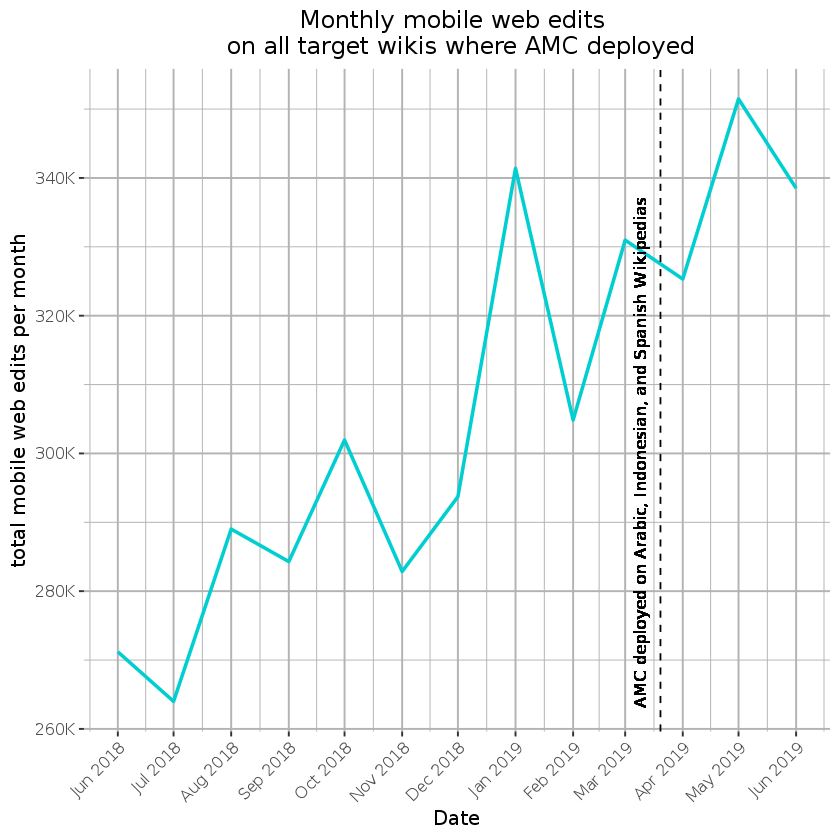

In [811]:
##Plot weekl overall mobile edits rate.

mobile_web_edit_monthly_overall <- mobile_web_edit_counts_clean %>%
filter(edit_type == 'mobile_web_edits') %>% 
mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
 ggplot(aes(x=date, y = total_mobile_edits)) + 
    geom_line(color = 'darkturquoise', size = 1 ) +
  geom_vline(xintercept = as.numeric(as.Date("2019-03-20")),
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=3E5, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    scale_y_continuous("total mobile web edits per month", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
    labs(title = "Monthly mobile web edits \n on all target wikis where AMC deployed") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"))

mobile_web_edit_monthly_overall
     
ggsave("Figures/mobile_web_edits_overall_monthly.png", mobile_web_edit_monthly_overall, width = 18, height = 9, units = "in", dpi = 150)

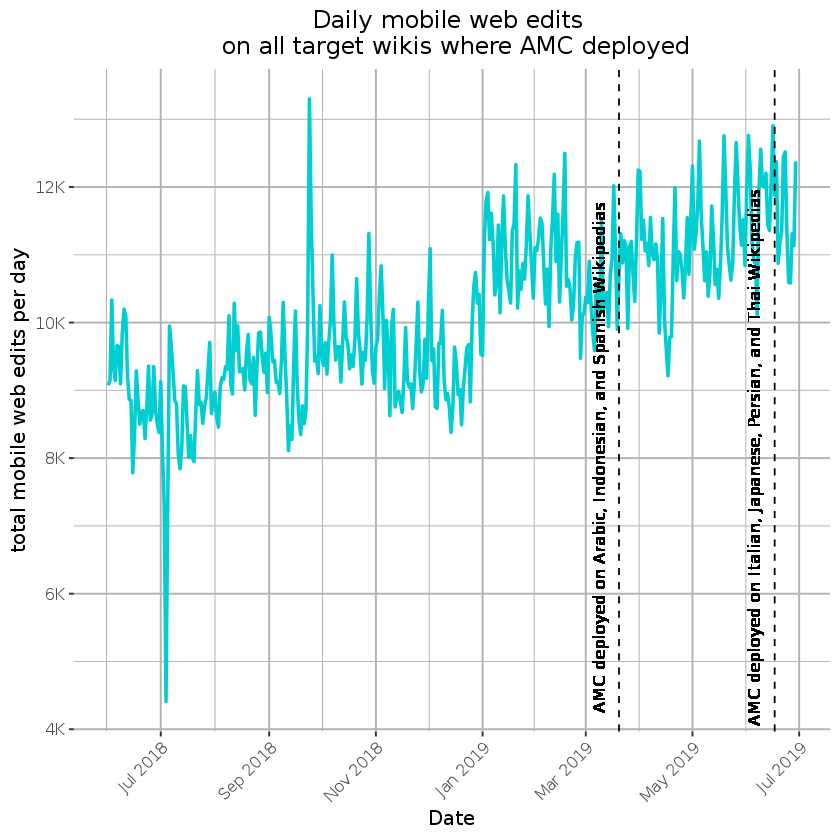

In [813]:
##Plot weekl overall mobile edits rate.

mobile_web_edit_daily_overall <- mobile_web_edit_counts_clean %>%
filter(edit_type == 'mobile_web_edits') %>% 
#mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
 ggplot(aes(x=date, y = total_mobile_edits)) + 
    geom_line(color = 'darkturquoise', size = 1 ) +
  geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=8E3, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2019-06-17'), y=8E3, label="AMC deployed on Italian, Japanese, Persian, and Thai Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    scale_y_continuous("total mobile web edits per day", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 months") +
    labs(title = "Daily mobile web edits \n on all target wikis where AMC deployed") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"))

mobile_web_edit_daily_overall
     
ggsave("Figures/mobile_web_edits_overall_daily.png", mobile_web_edit_daily_overall, width = 18, height = 9, units = "in", dpi = 150)

There was a steady increase in total mobile web edits the past year. AMC was deployed to sets of target wikis on March 20, 2019 and June 17, 2019 but was not yet promoted. We will continue to monitor trend following full deployement and promotion of AMC. 

### Mobile web edit rate by edit count ##

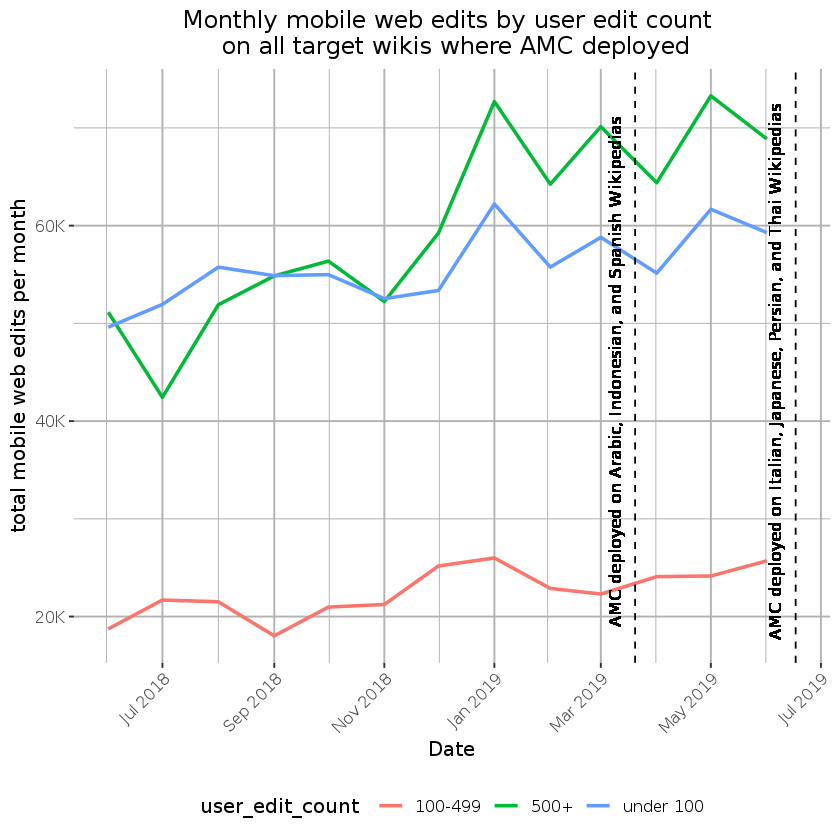

In [800]:
## Plot of overall mobile web edit rate by user edit count

mobile_web_edit_monthly_byuser <- mobile_web_edit_counts_clean %>%
    filter(edit_type == 'mobile_web_edits',
          user_edit_count != 'undefined') %>% ### remove undefined user edit counts
    mutate(date = floor_date(date, "month")) %>%
    group_by(date, user_edit_count) %>%
    summarise(total_mobile_edits = sum(edit_count))%>%
    ggplot(aes(x=date, y = total_mobile_edits, color = user_edit_count)) + 
    geom_line(size = 1)+
    scale_y_continuous("total mobile web edits per month", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 months", limits = c()) +
    labs(title = "Monthly mobile web edits by user edit count \n on all target wikis where AMC deployed") +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=4.5E4, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2019-06-17'), y=4.5E4, label="AMC deployed on Italian, Japanese, Persian, and Thai Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

ggsave("Figures/mobile_web_edits_byeditcount.png", mobile_web_edit_monthly_byuser, width = 18, height = 9, units = "in", dpi = 150)

mobile_web_edit_monthly_byuser

In [653]:
##Calculate overall YOY increase for 100+ and 500+ editors across all target wikis

mobile_web_edit_100 <- mobile_web_edit_counts_clean %>%
    filter(user_edit_count == '100-499') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


mobile_web_edit_500 <- mobile_web_edit_counts_clean %>%
    filter(user_edit_count == '500+') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


In [654]:
# yoy table
edit_count <- c('100+', '500+')
mobile_web_editcount_yoy <- rbind(mobile_web_edit_100[13,], mobile_web_edit_500[13,])

mobile_web_editcount_yoy$edit_count= edit_count

mobile_web_editcount_yoy

date,total_mobile_edits,yearOverYear,edit_count
<date>,<dbl>,<dbl>,<chr>
2019-06-01,26227,0.3994451,100+
2019-06-01,70064,0.3700162,500+


### Mobile web edit rate by target wiki ##

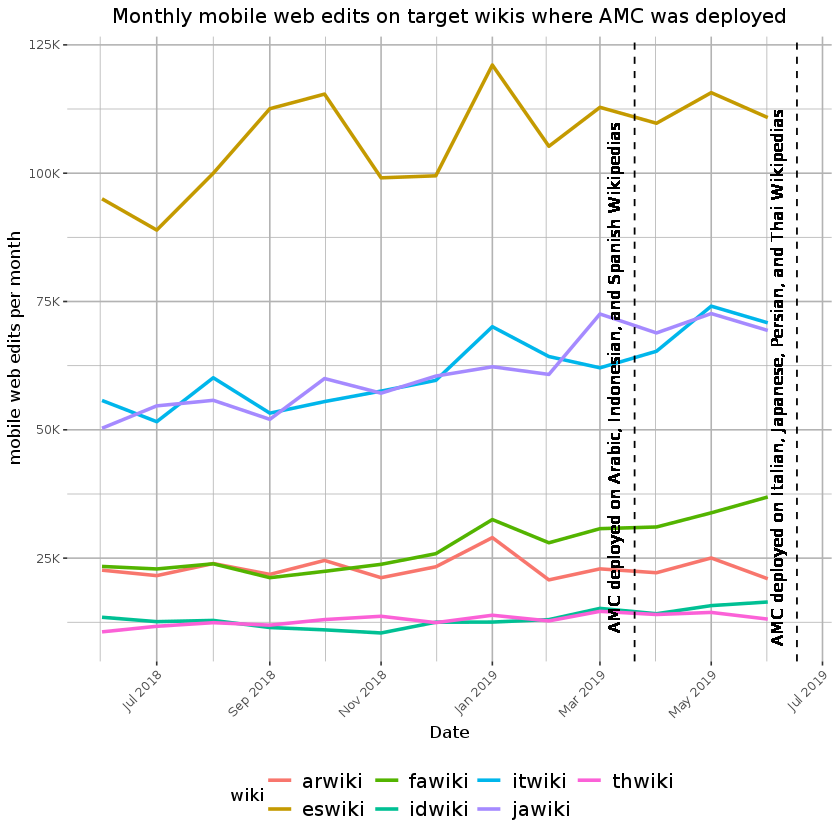

In [774]:
##Plot of mobile web edits by target wiki.

mobile_web_edit_monthly_bywiki <- mobile_web_edit_counts_clean %>%
     filter(edit_type == 'mobile_web_edits',
           wiki %in% c('eswiki', 'arwiki', 'idwiki', 'itwiki', 'jawiki', 'fawiki', 'thwiki'))%>%
     mutate(date = floor_date(date, "month")) %>%
    group_by(date, wiki)%>%
    summarise(monthly_edits = sum(edit_count)) %>%
    ggplot(aes(x=date, y = monthly_edits, color = wiki)) + 
    geom_line(size = 1) +
    geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=6E4, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2019-06-17'), y=6E4, label="AMC deployed on Italian, Japanese, Persian, and Thai Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    scale_y_continuous("mobile web edits per month", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 months", limits = c()) +
    labs(title = "Monthly mobile web edits on target wikis where AMC was deployed") +
    ggthemes::theme_tufte(base_size = 10, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position= "bottom",
        legend.text=element_text(size = 12))

mobile_web_edit_monthly_bywiki

ggsave("Figures/mobile_web_edits_bywiki.png", mobile_web_edit_monthly_bywiki, width = 18, height = 9, units = "in", dpi = 150)

In [777]:

##Calculate YOY change for target wikis 
#Arwiki
mobile_web_edit_arwiki <- mobile_web_edit_counts_clean %>%
    filter(wiki == 'arwiki',
          edit_type == 'mobile_web_edits') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


#EsWiki
mobile_web_edit_eswiki <- mobile_web_edit_counts_clean %>%
    filter(wiki == 'eswiki',
          edit_type == 'mobile_web_edits') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


#idwiki
mobile_web_edit_idwiki <- mobile_web_edit_counts_clean %>%
    filter(wiki == 'idwiki',
          edit_type == 'mobile_web_edits') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


#itwiki
mobile_web_edit_itwiki <- mobile_web_edit_counts_clean %>%
    filter(wiki == 'itwiki',
          edit_type == 'mobile_web_edits') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


#jawiki
mobile_web_edit_jawiki <- mobile_web_edit_counts_clean %>%
    filter(wiki == 'jawiki',
          edit_type == 'mobile_web_edits') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


#fawiki
mobile_web_edit_fawiki <- mobile_web_edit_counts_clean %>%
    filter(wiki == 'fawiki',
          edit_type == 'mobile_web_edits') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)

#thwiki
mobile_web_edit_thwiki <- mobile_web_edit_counts_clean %>%
    filter(wiki == 'thwiki',
          edit_type == 'mobile_web_edits') %>%
    mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(total_mobile_edits = sum(edit_count)) %>%
  arrange(date) %>%
mutate(yearOverYear= total_mobile_edits/lag(total_mobile_edits,12) -1)


In [778]:
# Create YoY Table
wiki_list <- c('arwiki', 'eswiki', 'idwiki', 'itwiki', 'jawiki', 'fawiki', 'thwiki')
mobile_web_edit_yoy <- rbind(mobile_web_edit_arwiki[13,], mobile_web_edit_eswiki[13,],
                            mobile_web_edit_idwiki[13,], mobile_web_edit_itwiki[13,],
                            mobile_web_edit_jawiki[13,], mobile_web_edit_fawiki[13,], mobile_web_edit_thwiki[13,])

mobile_web_edit_yoy$wiki= wiki_list

mobile_web_edit_yoy

date,total_mobile_edits,yearOverYear,wiki
<date>,<dbl>,<dbl>,<chr>
2019-06-01,20978,-0.07406427,arwiki
2019-06-01,110830,0.16655790,eswiki
2019-06-01,16457,0.22084570,idwiki
2019-06-01,70841,0.27139755,itwiki
2019-06-01,69357,0.37859273,jawiki
2019-06-01,36918,0.57883933,fawiki
2019-06-01,13119,0.23322053,thwiki


There was a YoY increase in the mobile web edit rate for each target wiki ranging; except for Arabic Wikipedia which had a slight drop (-7.4%). The highest YoY increase was on Persian Wikipeida (57.8%).


### Proportion of mobile web edits made with AMC edit interface  ###

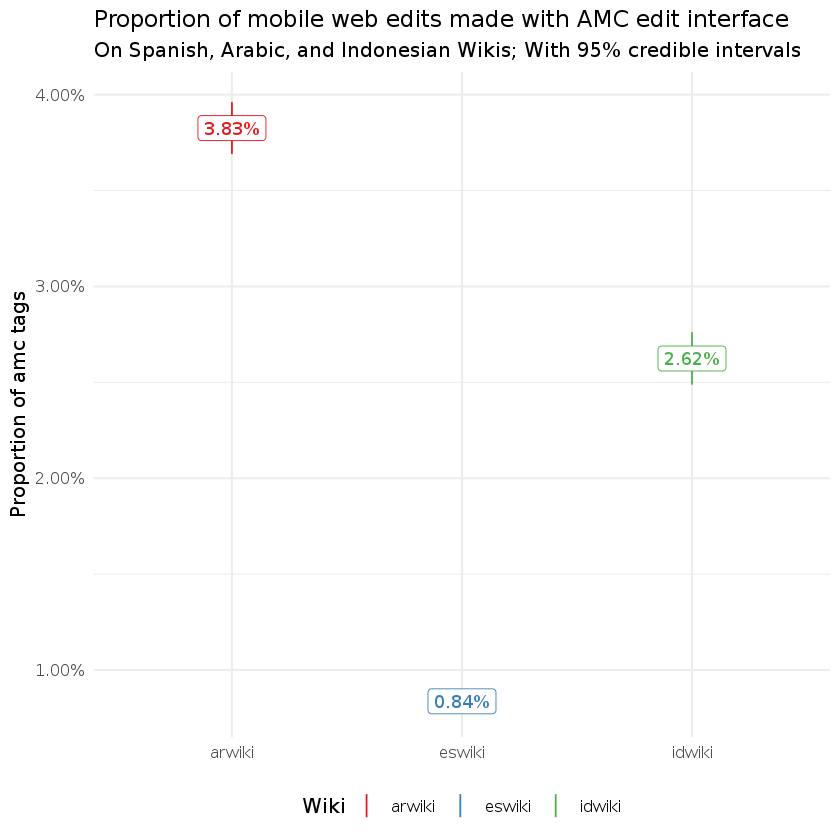

In [779]:
#Overall Proportion of mobile web edits tagged with AMC. 
#Reviewed only Spanish, Arabic and Indonesian since AMC has been deployed the longest on those wikis.
# Note: Analysis assumes that only mobile web edits are tagged with AMC (not desktop or app).

amc_edits_prop <- mobile_web_edit_counts %>%
    filter(date >= "2019-03-20", #deployment date
          wiki %in% c('eswiki', 'arwiki', 'idwiki')) %>% 
        group_by(wiki) %>%
        summarise(mobile_web_edits = sum(mobile_web_edits),
                 amc_edits = sum(amc_edits)) %>%
        cbind(
                as.data.frame(binom:::binom.bayes(x = .$amc_edits, n = .$mobile_web_edits, conf.level = 0.95, tol = 1e-9))
        ) %>%
        ggplot(aes(x = wiki, y = mean, color = wiki, ymin = lower, ymax = upper)) +
        geom_linerange() +
        geom_label(aes(label = sprintf("%.2f%%", 100 * mean)), show.legend = FALSE) +
        ggplot2::scale_y_continuous(labels = scales::percent_format()) +
        ggplot2::scale_color_brewer("Wiki", palette = "Set1") +
        ggplot2::labs(x = NULL, y = "Proportion of amc tags", title = "Proportion of mobile web edits made with AMC edit interface", subtitle = "On Spanish, Arabic, and Indonesian Wikis; With 95% credible intervals") +
        wmf::theme_min(plot.title = element_text(size=14))

amc_prop

ggsave("Figures/amc_edit_prop_bywiki.png", amc_edits_prop, width = 18, height = 9, units = "in", dpi = 150)

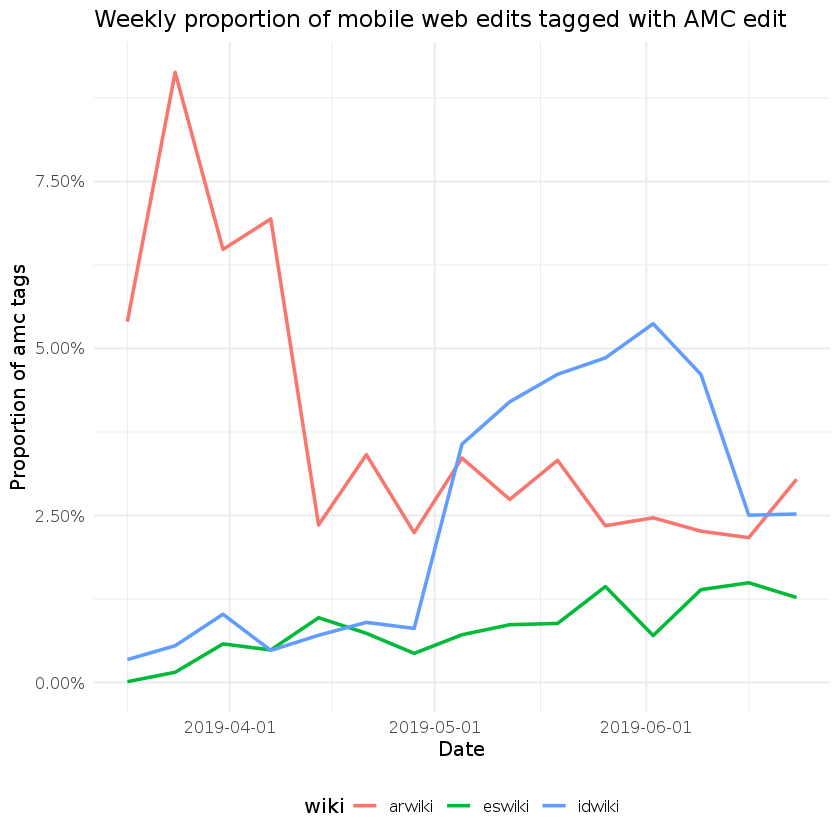

In [781]:
## Plot change daily change in proportion of amc edits. (e.g. daily serp offset)
# Note: Analysis assumes that only mobile web edits are tagged with AMC (not desktop or app).

amc_prop_weekly <- mobile_web_edit_counts %>%
        filter(date >= "2019-03-20", #deployment date
          wiki %in% c('eswiki', 'arwiki', 'idwiki')) %>% 
        mutate(date = floor_date(date, "week")) %>%
        group_by(date, wiki) %>%
        summarise(mobile_web_edits = sum(mobile_web_edits),
                 amc_edits = sum(amc_edits)) %>%
        mutate(prop_amc = amc_edits/mobile_web_edits) %>%
        ggplot(aes(x = date, y= prop_amc, color = wiki)) +
        geom_line(size = 1) +
        scale_x_date("Date", labels = date_format("%Y-%m-%d"), date_breaks = "1 month")  +
        scale_y_continuous("Proportion of amc tags", labels = scales::percent_format()) +
        labs(title = "Weekly proportion of mobile web edits tagged with AMC edit") +
        wmf::theme_min(plot.title = element_text(size=14))

amc_prop_weekly

ggsave("Figures/amc_edit_prop_bywiki_weekly.png", amc_prop_weekly, width = 18, height = 9, units = "in", dpi = 150)

## Retention Rate ##

The retention rate for opt-in advanced mobile mode amongst:
- overall across all target wikis where deployed 
- eswiki, arwiki, idwiki, thwiki, itwiki, jawiki, fawiki 
- Users with 100+ edits, 500+ edits (cumulative).

Target: At least 60% retention.
Measured using the opt-in/opt-out button (done in T211197 using the PrepUpdate mf_amc_optin). This is set to true when a user opts out and set to false when they opt in. 
Schema: https://meta.wikimedia.org/wiki/Schema:PrefUpdate

Notes:
- Some general concerns about the data quality of the PrefUpdate schema, regarding duplicate events. [T218835](https://phabricator.wikimedia.org/T218835)
-  Toggle is on the mobile settings page for logged in users server and client side
- The feature is available as a separate setting (not a part of beta)


In [ ]:
##Query retention rates on target wikis with breakdown by user edit counts

# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

query <- 
"with amc_optins as (
SELECT CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
wiki, 
event.isdefault as amc_selection,
event.userid as userid
FROM event_sanitized.prefupdate 
WHERE event.property = 'mf_amc_optin' 
AND wiki IN ('eswiki', 'arwiki', 'idwiki', 'itwiki', 'jawiki', 'fawiki', 'thwiki') 
AND year = 2019 AND ((month >= 3 and day >=20) OR (month >= 4))
),
edits as (
SELECT
event_user_id as userid,
wiki_db,
CASE
    WHEN max(event_user_revision_count) is NULL THEN 'unregistered'
    WHEN max(event_user_revision_count) < 100 THEN 'under 100'
    WHEN max(event_user_revision_count) < 500 THEN '100-499'
    ELSE '500+'
    END AS user_edit_count
FROM wmf.mediawiki_history
WHERE snapshot = '2019-06' 
Group by event_user_id, wiki_db
)
SELECT date, wiki, amc_selection, user_edit_count, COUNT(*) as n_opt
FROM amc_optins
LEFT JOIN edits
ON amc_optins.userid = edits.userid and 
amc_optins.wiki = edits.wiki_db
GROUP BY date, wiki, amc_selection, user_edit_count"


results <- collect(sql(query))
save(results, file="R/Data/amc_retention_rates.RData")


In [671]:
load("Data/amc_retention_rates.RData")
amc_retention_rates <- results

In [672]:
amc_retention_rates$date <- as.Date(amc_retention_rates$date, format = "%Y-%m-%d")
#Revise amc_opt_out to factor and clarfiy TRUE and FALSE labels. 
amc_retention_rates$amc_selection %<>% factor(c(TRUE, FALSE), c("amc_opt_out", "amc_opt_in"))


### Overall Retention Rate of opt-in AMC ###

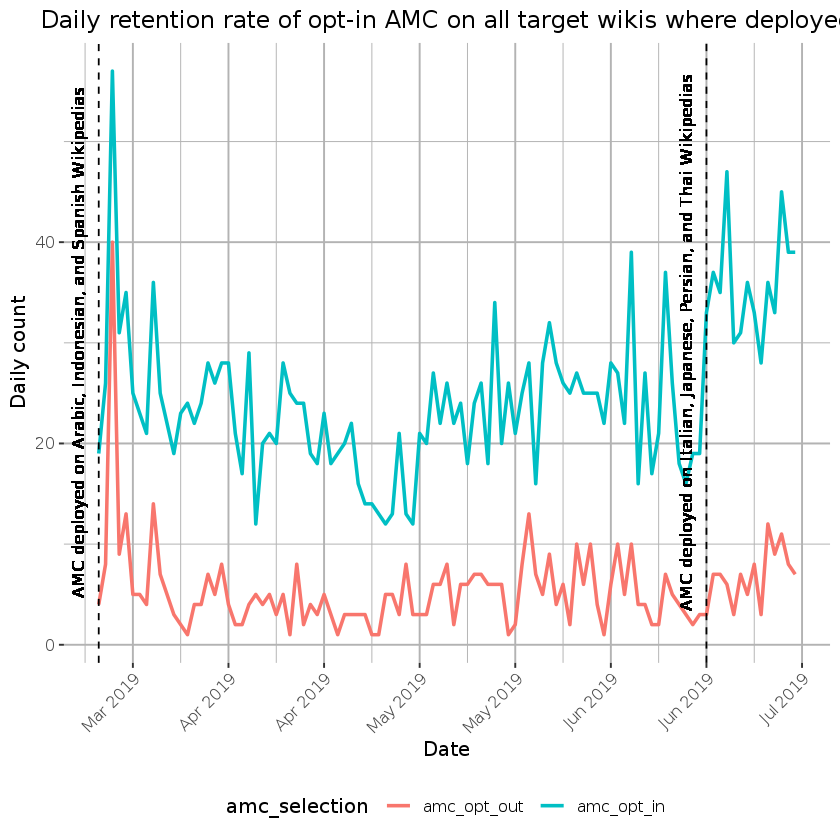

In [814]:
##Look at Overall Retention Rate
amc_retention_overall_daily <- amc_retention_rates %>%
filter(date <= '2019-06-30') %>% #filter out July due to incomplete history in mediawikihistory table
    #mutate(date = floor_date(date, "week")) %>%
    group_by(date, amc_selection) %>% 
    summarise(n_opt = sum(n_opt)) %>% 
    ggplot(aes(x=date, y = n_opt, color = amc_selection)) + 
    geom_line(size = 1)+
    scale_y_continuous("Daily count", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 weeks") +
    labs(title = "Daily retention rate of opt-in AMC on all target wikis where deployed") +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=30, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2019-06-17'), y= 30, label="AMC deployed on Italian, Japanese, Persian, and Thai Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

ggsave("Figures/amc_retention_daily.png", amc_retention_overall_daily, width = 18, height = 9, units = "in", dpi = 150)
amc_retention_overall_daily

### Retention Rate of opt-in AMC by Target Wiki ###

In [784]:
# Overall retention rate

amc_retention_overall_percent <- amc_retention_rates %>%
filter(date <= '2019-06-30') %>% #filter out July due to incomplete history in mediawikihistory table
group_by(wiki, amc_selection) %>%
summarise(n_opt = sum(n_opt)) %>%
spread(amc_selection, n_opt)%>%
group_by(wiki) %>%
mutate(prop_opt_in_percent = amc_opt_in/(amc_opt_out+amc_opt_in)*100)

head(amc_retention_overall_percent)

wiki,amc_opt_out,amc_opt_in,prop_opt_in_percent
<chr>,<dbl>,<dbl>,<dbl>
arwiki,233,1192,83.64912
eswiki,206,723,77.82562
fawiki,12,119,90.83969
idwiki,92,420,82.03125
itwiki,5,39,88.63636
jawiki,17,45,72.58065


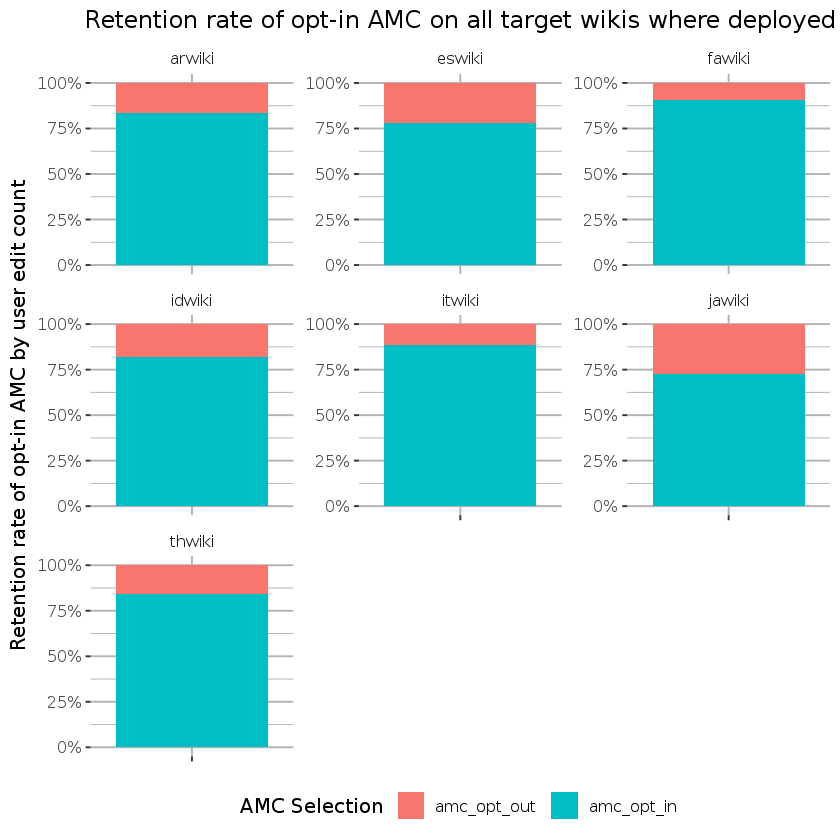

In [815]:
##Overall proportion of AMC retention rates on each target wiki

amc_retention_props <- amc_retention_rates %>%
    filter(date <= '2019-06-30') %>% #filter out July due to incomplete date
    group_by(wiki, amc_selection) %>% 
    summarise(n_opt = sum(n_opt)) %>% 
    ggplot(aes(x=factor(1), y= n_opt, fill = amc_selection)) + 
    geom_col(position="fill") +
    scale_y_continuous(labels = scales::percent_format()) +
    facet_wrap(~wiki, scale = "free_y") +
    labs(title = "Retention rate of opt-in AMC on all target wikis where deployed",
        fill = "AMC Selection",
        x= NULL,
        y = "Retention rate of opt-in AMC by user edit count") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")
ggsave("Figures/amc_retention_prop_bywiki.png", amc_retention_props, width = 18, height = 9, units = "in", dpi = 150)
amc_retention_props 

On target wikis, retention rates ranged from 72.6% (Japanese Wikipedia) to 90.8% (Persian Wikipedia).

### Retention Rate of opt-in AMC by user edit count ###

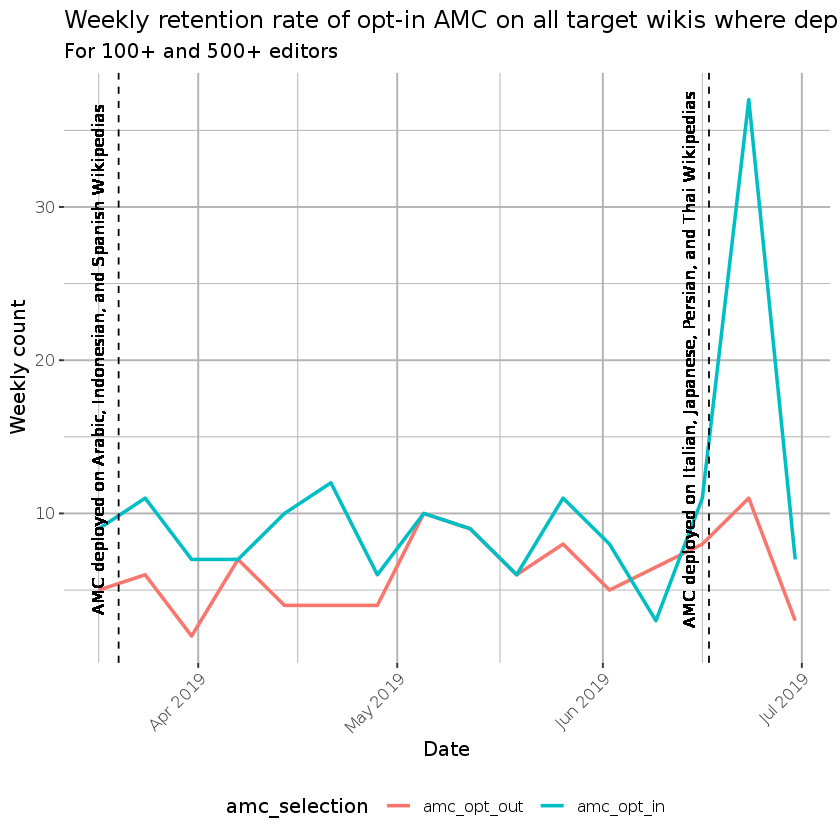

In [816]:
### Overall AMC Retention Rate Broken down by 100+ and 500+ editor groups

amc_retention_overall_byeditcount <- amc_retention_rates %>%
    filter(date <= '2019-06-30') %>% #filter out July due to incomplete history in mediawikihistory table
    filter(user_edit_count == '100-499'| user_edit_count == '500+') %>%
    mutate(date = floor_date(date, "week")) %>%
    group_by(date, amc_selection) %>% 
    summarise(n_opt = sum(n_opt)) %>% 
    ggplot(aes(x=date, y = n_opt, color = amc_selection)) + 
    geom_line(size = 1)+
    scale_y_continuous("Weekly count", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
    labs(title = "Weekly retention rate of opt-in AMC on all target wikis where deployed",
        subtitle = "For 100+ and 500+ editors") +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=20, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2019-06-17'), y=20, label="AMC deployed on Italian, Japanese, Persian, and Thai Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

amc_retention_overall_byeditcount
ggsave("Figures/amc_retention_weekly_byeditcount_.png", amc_retention_overall_byeditcount, width = 18, height = 9, units = "in", dpi = 150)

In [681]:
# Overall retention rate for 100+ and 500+ editors

amc_retention_prop_overall_byeditor <- amc_retention_rates %>%
 filter(date <= '2019-06-30',
         user_edit_count == '100-499' | user_edit_count == '500+') %>% #Filter to key user groups and remove incomplete July data
group_by(user_edit_count, amc_selection) %>%
summarise(n_opt = sum(n_opt)) %>%
spread(amc_selection, n_opt) %>%
group_by(user_edit_count) %>%
mutate(prop_opt_in_perct = amc_opt_in/(amc_opt_out+amc_opt_in)*100)

amc_retention_prop_overall_byeditor


user_edit_count,amc_opt_out,amc_opt_in,prop_opt_in_perct
<chr>,<dbl>,<dbl>,<dbl>
100-499,21,51,70.83333
500+,71,113,61.41304


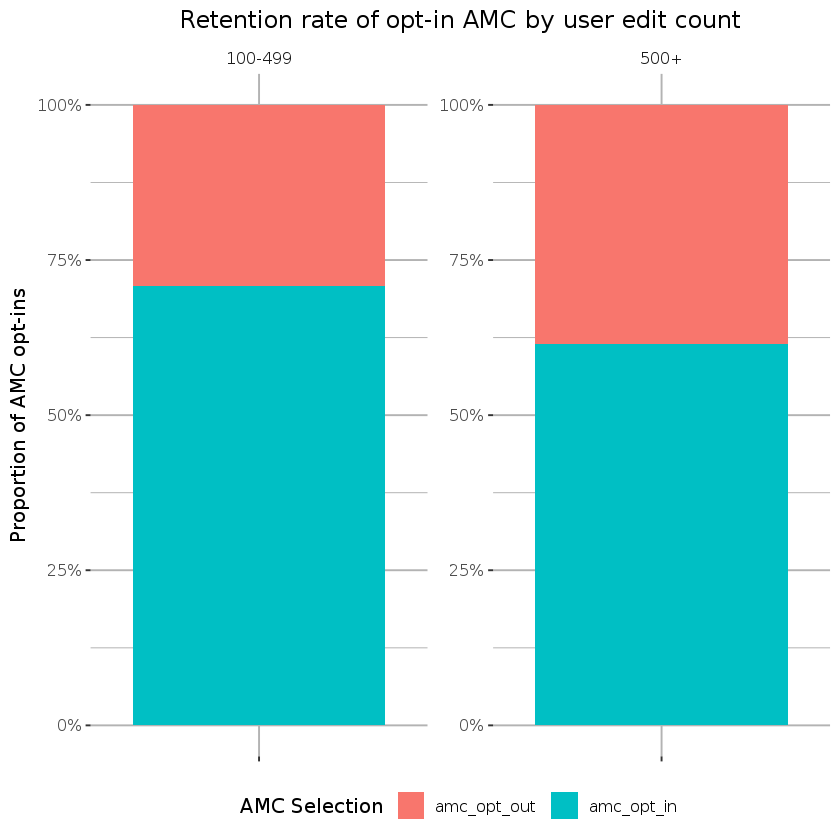

In [790]:
##Overall retention rate proportion among 100+ and 500+ editors

amc_retention_props_byeditor <- amc_retention_rates %>%
   filter(date <= '2019-06-30',
         user_edit_count == '100-499' | user_edit_count == '500+') %>% #Filter to key user groups and remove incomplete July data
    group_by(user_edit_count, amc_selection) %>% 
    summarise(n_opt = sum(n_opt))%>% 
    ungroup()%>%
    ggplot(aes(x=factor(1), y= n_opt, fill = amc_selection)) + 
    geom_col(position="fill") +
    scale_y_continuous(labels = scales::percent_format()) +
    facet_wrap(~ user_edit_count, scale = "free_y") +
    labs(title = "Retention rate of opt-in AMC by user edit count",
        fill = "AMC Selection",
        x = NULL,
        y = "Proportion of AMC opt-ins") +
  ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

ggsave("Figures/amc_retention_byeditcount.png", amc_retention_props_byeditor, width = 18, height = 9, units = "in", dpi = 150)
amc_retention_props_byeditor

There was a 70.8% overall retention rate limited to users with 100+ and  61.4% rate limited to users with 500+ edits (time period: March 20, 2019-June 30, 2019)

## Moderation Actions on Mobile Web ##

Target: 10% increase from last year - via the [logs](https://www.mediawiki.org/wiki/Manual:Logging_table) - not looking at AMC only but overall.
Moderation actions are defined in [T213461](https://phabricator.wikimedia.org/T213461)

Note: 
- When the following actions are executed from an AMC opted-in account, they should be tagged with both advanced mobile edit and mobile web edit in the corresponding public log. 
- This analysis currently just includes the increase in moderation actions across all target wiki on mobile web and is not limited to action tagged as AMC.

Final moderation action list:

Using the ct_tag table
- undo (under ct tags tag_name = 'mw-undo'; should show up in user contributions)
- rollback (under ct tags tag_name = 'mw-rollback'; should show up in user contributions)

Using the logging table
- blocking users (log_action = 'block', from log table)
- unblocking (log_action = 'unblock', from log table)
- deleting (log_action = 'delete', from log table)
- protecting pages (log_action = 'protect', from log table)
- moving pages (log_action = 'move', from log table)
- thanks (log_action = 'thank')
- approving pending changes. Note that (per the [documentation](https://meta.wikimedia.org/wiki/Flagged_Revisions), this feature is only available on three of the wikis from the initial AMC deployment, namely arwiki, fawiki idwiki.


TODO:
- (enwiki-specific:) reviewing new pages (cf. Special:NewPagesFeed)
-  other reverts (that are not done via either undo or rollback)
- Investigate AMC and mobile web edit tagging of moderation actions to ensure they are being tagged correctly.Subtask to create and vet query [T220148](https://phabricator.wikimedia.org/T220148)


In [689]:
target_wikis <- c(
   "eswiki" = "Spanish", "jawiki" = "Japanese", 
    "itwiki" = "Italian", "fawiki" = "Persian", "arwiki" = "Arabic",  
    "idwiki" = "Indonesian", "thwiki" = "Thai"
)

In [305]:
## Overall rate for logging table actions on mobile web (not limited to AMC tags). June 2018-June 2019
query <- "SELECT 
    DATE(LEFT(logging.log_timestamp, 8)) as date,
    SUM(If(logging.log_type = 'block' and logging.log_action = 'block', 1, 0)) as num_block,
    SUM(If(logging.log_type = 'block' and logging.log_action = 'unblock', 1, 0)) as num_unblock,
    SUM(If(logging.log_type = 'delete' and logging.log_action = 'delete', 1, 0)) as num_delete,
    SUM(If(logging.log_type = 'protect' and logging.log_action = 'protect', 1, 0)) as num_protect,
    SUM(If(logging.log_type = 'move' and logging.log_action = 'move', 1, 0)) as num_move,
    SUM(If(logging.log_type = 'thanks' and logging.log_action = 'thank', 1, 0)) as num_thank,
    SUM(If(logging.log_type = 'review' and logging.log_action = 'approve', 1, 0)) as num_approve
FROM logging as logging
INNER JOIN  (
    SELECT ct_rev_id as rev_id,
    change_tag_def.ctd_name as tag_name,
    change_tag.ct_log_id as log_id
  FROM change_tag
  INNER JOIN change_tag_def ON (
    change_tag.ct_tag_id = change_tag_def.ctd_id
  )
) as ct
ON logging.log_id = ct.log_id
WHERE logging.log_timestamp >= '20180600000000' and 
logging.log_timestamp <= '20190630000000' and 
ct.tag_name like '%mobile edit%' and 
        (ct.tag_name like '%mobile web edit%' or ct.tag_name not like '%mobile app edit%') 
GROUP By DATE(LEFT(log_timestamp, 8))"

In [306]:
moderation_counts_log <- map_df(
        set_names(names(target_wikis), names(target_wikis)),
        ~ shhh(wmf::mysql_read(glue(query), .x)),
        .id = "wiki"
    ) 
 save(moderation_counts_log, file="Data/moderation_counts_log.RData")

In [311]:
load("Data/moderation_counts_log.RData")
moderation_counts_log$date <- as.Date(moderation_counts_log$date, format = "%Y-%m-%d")

In [307]:
# Query to collect unblock and rollback from the user table. Done using change tags now available in mediawiki_history

# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

query <- "select
    date_format(event_timestamp, 'yyyy-MM-dd') as date,
    wiki_db as wiki,
    sum(cast(mw_rollback as int)) as num_rollback,
    sum(cast(mw_undo as int)) as num_undo
from (
    select
        wiki_db,
        event_timestamp,
        array_contains(revision_tags, 'mw-rollback') as mw_rollback, 
        array_contains(revision_tags, 'mw-undo') as mw_undo
    from wmf.mediawiki_history
    where
        event_timestamp IS NOT NULL and
        array_contains(revision_tags, 'mobile web edit') and
        wiki_db in ('eswiki', 'arwiki', 'idwiki', 'itwiki', 'jawiki', 'fawiki', 'thwiki') and
        event_timestamp >= '2018-06-01' and   event_timestamp <= '2019-06-30' and 
        snapshot = '2019-06'
) edits
group by wiki_db, date_format(event_timestamp, 'yyyy-MM-dd')"


results <- collect(sql(query))
save(results, file="R/Data/moderation_counts_ct.RData")

ERROR: Error in UseMethod("collect"): no applicable method for 'collect' applied to an object of class "c('sql', 'character')"


In [312]:
load("Data/moderation_counts_ct.RData")
moderation_counts_ct <- results
moderation_counts_ct$date <- as.Date(moderation_counts_ct$date, format = "%Y-%m-%d")

date,wiki,num_rollback,num_undo
<date>,<chr>,<dbl>,<dbl>
2018-11-23,itwiki,0,0
2018-10-30,itwiki,0,0
2018-09-15,itwiki,0,0
2018-10-25,idwiki,0,0
2019-03-03,fawiki,0,0
2019-02-18,eswiki,0,2


In [313]:
##Join the two moderation count tables
moderation_counts_all <- inner_join(moderation_counts_log, moderation_counts_ct, 
                                     by = c("date", "wiki"))


### Moderation actions by action type ###

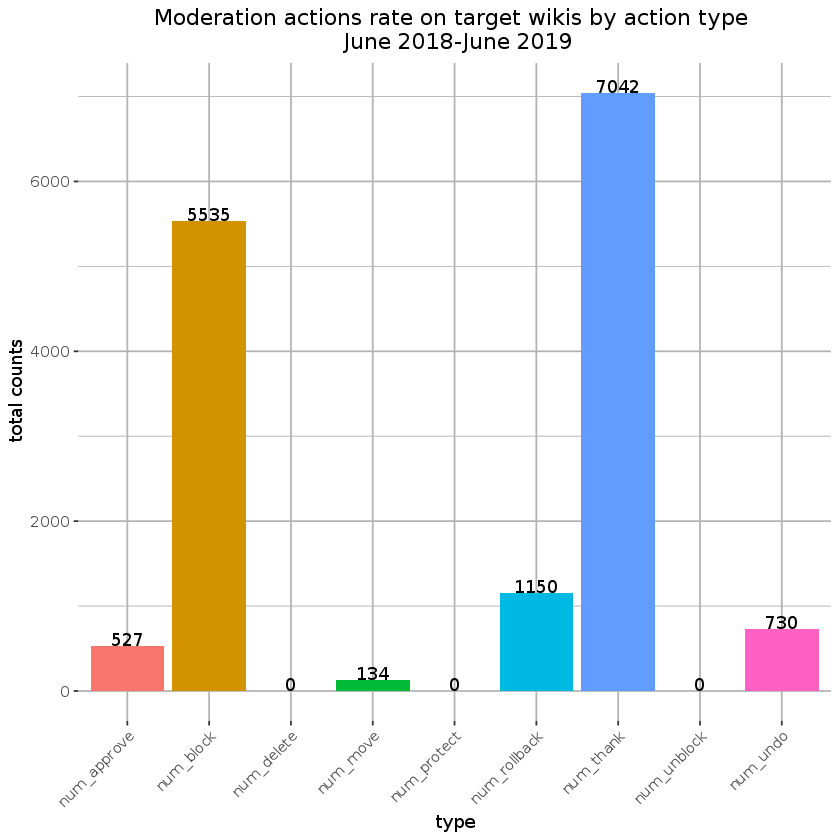

In [792]:
moderation_counts_bytype_total <- moderation_counts_all %>%
    gather(action_type, action_count, num_block:num_undo) %>%
    filter(date <= '2019-06-30') %>%
    group_by(action_type) %>% 
    summarise(action_count = sum(action_count)) %>%
    ggplot(aes(x=action_type, y= action_count, fill = action_type)) +
    geom_bar(stat='identity') +
    geom_text(aes(label=action_count), vjust=0) +
 labs(title = "Moderation actions rate on target wikis by action type \n June 2018-June 2019") +
     ylab("total counts")+
     xlab("type") +
ggthemes::theme_tufte(base_size = 11, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position = "none")
        
moderation_counts_bytype_total 
ggsave("Figures/moderation_counts_bytype_total.png", moderation_counts_bytype_total, width = 18, height = 9, units = "in", dpi = 150)

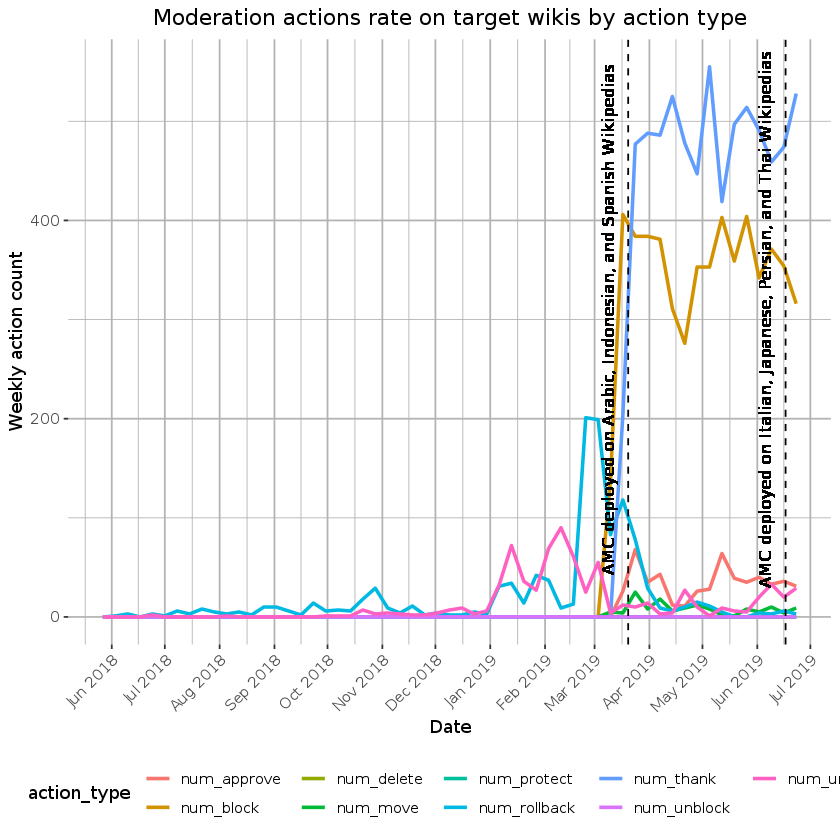

In [794]:
#Plot overall moderation actions by action type

moderation_counts_bytype_weekly <- moderation_counts_all %>%
    gather(action_type, action_count, num_block:num_undo) %>%
    filter(date <= '2019-06-30') %>% #filter out July due to incomplete date and pre March due to untagged actions
mutate(date = floor_date(date, "week")) %>%
group_by(date, action_type) %>% 
    summarise(action_count = sum(action_count)) %>% 
    ggplot(aes(x=date, y = action_count, color = action_type)) + 
    geom_line(size = 1)+
    scale_y_continuous("Weekly action count", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
    labs(title = "Moderation actions rate on target wikis by action type") +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=300, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2019-06-17'), y=300, label="AMC deployed on Italian, Japanese, Persian, and Thai Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    ggthemes::theme_tufte(base_size = 11, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

moderation_counts_bytype_weekly
ggsave("Figures/moderation_counts_bytype_weekly.png", moderation_counts_bytype_weekly , width = 18, height = 9, units = "in", dpi = 150)

There is a sudden spike in actions around March 2019 but that is likely due to the timing of when mobile web edits tags were added to all moderation actions. There are no significant changes in the rate of each moderation action type use from March 2019 to June 2019. 

### Moderation actions by wiki ###

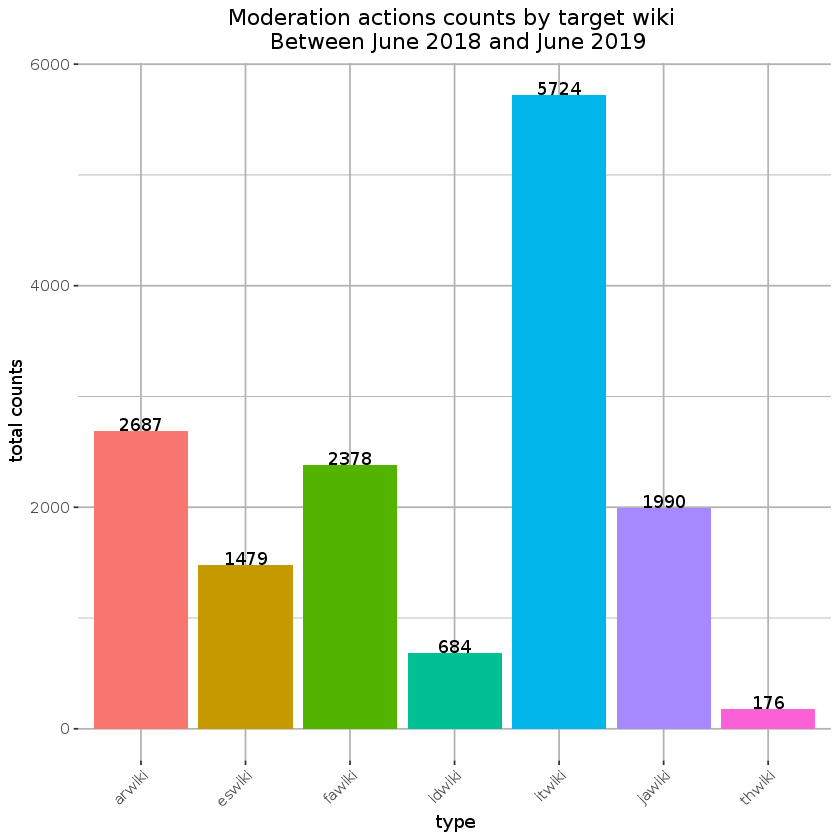

In [795]:
#Total Counts of moderation action by wiki

moderation_counts_bywiki_total <- moderation_counts_all %>%
    gather(action_type, action_count, num_block:num_undo) %>%
    filter(date <= '2019-06-30') %>%
    group_by(wiki) %>% 
    summarise(action_count = sum(action_count)) %>%
    ggplot(aes(x=wiki, y= action_count, fill = wiki)) +
    geom_bar(stat='identity') +
    geom_text(aes(label=action_count), vjust=0) +
 labs(title = "Moderation actions counts by target wiki \n Between June 2018 and June 2019") +
     ylab("total counts")+
     xlab("type") +
ggthemes::theme_tufte(base_size = 11, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position = "none")

moderation_counts_bywiki_total
ggsave("Figures/moderation_counts_bywiki_total.png", moderation_counts_bywiki_total, width = 18, height = 9, units = "in", dpi = 150)

Italian Wikipedia had the highest number of moderation actions on mobile web the past year (5,724) while Thai Wikipedia had the lowest (176).

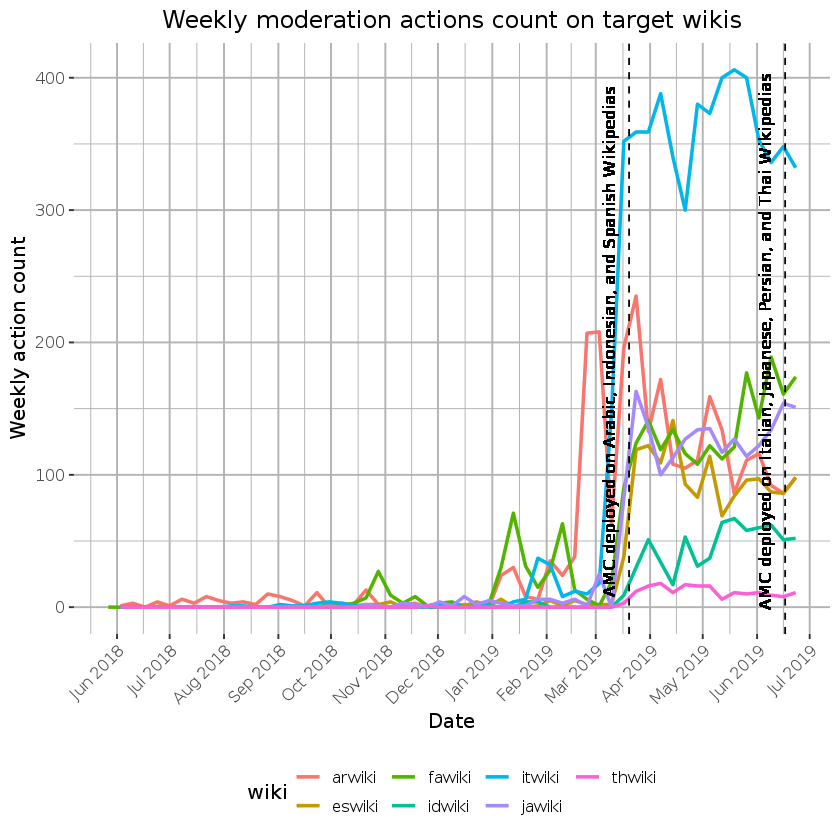

In [796]:
#Plot overall moderation actions weekly

moderation_counts_bywiki_weekly <- moderation_counts_all %>%
    gather(action_type, action_count, num_block:num_undo) %>%
    arrange(desc(date)) %>%
    filter(date <= '2019-06-30') %>% #filter out July due to incomplete date and pre March due to untagged actions
mutate(date = floor_date(date, "week")) %>%
group_by(date, wiki) %>% 
    summarise(action_count = sum(action_count)) %>% 
    ggplot(aes(x=date, y = action_count, color = wiki)) + 
    geom_line(size = 1)+
    scale_y_continuous("Weekly action count", labels = polloi::compress) +
    scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
    labs(title = "Weekly moderation actions count on target wikis") +
geom_vline(xintercept = vertical_lines,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2019-03-20'), y=200, label="AMC deployed on Arabic, Indonesian, and Spanish Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2019-06-17'), y=200, label="AMC deployed on Italian, Japanese, Persian, and Thai Wikipedias"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position="bottom")

moderation_counts_bywiki_weekly
ggsave("Figures/moderation_counts_bywiki_weekly.png", moderation_counts_bywiki_weekly, width = 18, height = 9, units = "in", dpi = 150)